## Predicting Handwritten Digits: MNIST Dataset
### Problem:
- **Objective**: Predict Handwritten Digits from the MNIST Dataset of 28x28 pixel grayscale images of handwritten digits (0-9)
- **How**: Building a Neural Network for Multi-Class Classification.
- **Dataset**: 28x28 pixel grayscale images of handwritten digits (0-9) (MNIST Dataset)
- **Target variable**: Digit from 0 to 9

### Steps:
**Load the Dataset**: MNIST dataset from Torchvision ([Link Here](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html))

**Preprocess the Data**:
  1) Define transforms for preprocessing the data (normalizing pixel values between 0 and 1)
  2) Load the train MNIST dataset
  3) Load the test MNIST dataset
  4) Create DataLoaders for train and test sets

**Build the Neural Network**: Feedforward Neural Network with the following layers:

*Input Layer*: Match the number of input features (28x28: px.px).

*Hidden Layers*: Two hidden layers with ReLU activation (64 and 32 units).

*Output Layer*: Ten neurons for the ten different digits (0-9).

**Train the Model**: 
 1) Use the Cross Entropy loss function and Adam optimizer. 
 2) Train for 10 epochs.
 3) Calculate and print the train loss during training.

**Evaluate the Model**:  
 1) Calculate test loss after training.
 2) Plot training loss curve
 3) Calculate R-squared
 4) Plot Confusion Matrix

In [13]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [14]:
# Define transforms for preprocessing the data (normalizing pixel values between 0 and 1)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [15]:
num_batches = len(train_loader)
print(f"Number of batches: {num_batches}")

Number of batches: 938


In [16]:
print(f" Shape of training data {train_dataset.data.shape}")
print(f" Shape of test data {test_dataset.data.shape}")

 Shape of training data torch.Size([60000, 28, 28])
 Shape of test data torch.Size([10000, 28, 28])


In [17]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

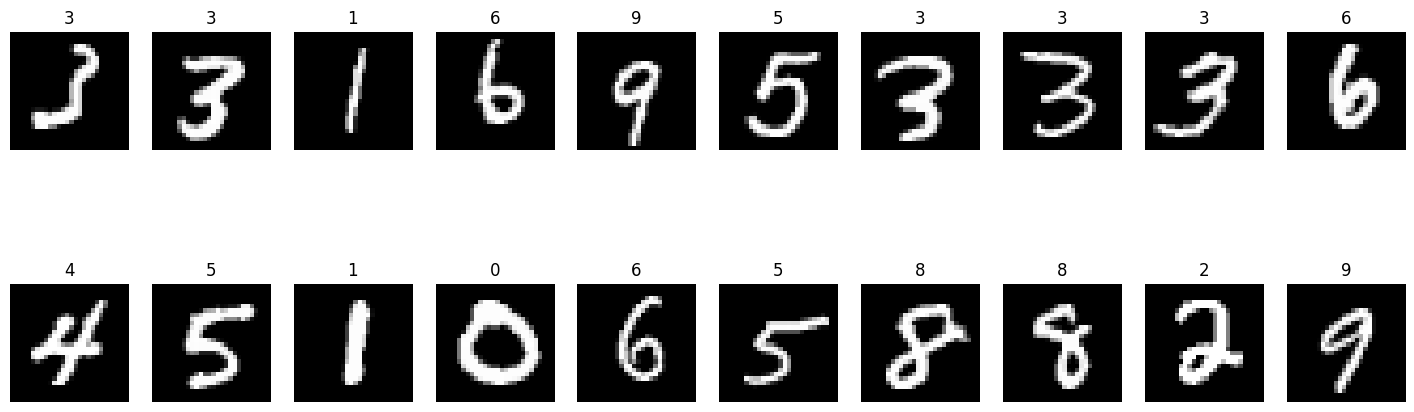

In [18]:
figure = plt.figure(figsize=(18, 6))
cols, rows = 10, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [19]:
class MnistNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(MnistNN, self).__init__()
        # Define the layers
        self.linear1 = nn.Linear(input_size, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, output_size)

    def forward(self, x):
        # Flatten the 28x28 images into a vector of size 784
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)

        return x

In [20]:
input_size = 28*28 #px*px
output_size = 10 #nº of digits, 0-9
model = MnistNN(input_size, output_size)

In [21]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [22]:
epochs = 10
train_losses = []

device = torch.device('cuda')

model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        loss_fn = loss(pred, labels)

        loss_fn.backward()
        optimizer.step()

        running_loss += loss_fn.item()
        #print(running_loss)
    # Print the average loss after each epoch
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 1/10, Loss: 0.4656
Epoch 2/10, Loss: 0.2519
Epoch 3/10, Loss: 0.1976
Epoch 4/10, Loss: 0.1627
Epoch 5/10, Loss: 0.1403
Epoch 6/10, Loss: 0.1233
Epoch 7/10, Loss: 0.1106
Epoch 8/10, Loss: 0.1009
Epoch 9/10, Loss: 0.0955
Epoch 10/10, Loss: 0.0851


In [24]:
correct = 0
total = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        _, predicted = torch.max(pred, 1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')

Accuracy on the test set: 96.18%


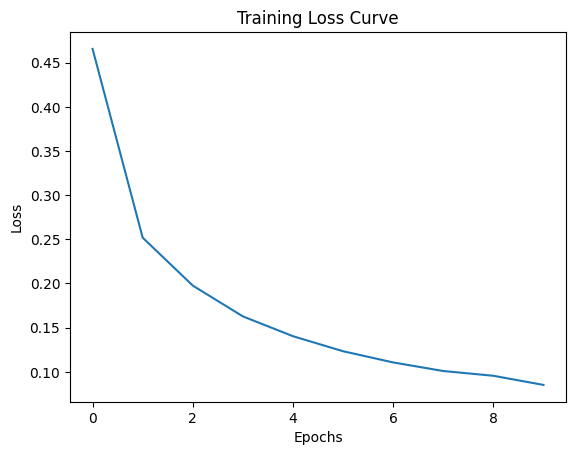

In [26]:
import matplotlib.pyplot as plt

# Plot the training & validation loss curve
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

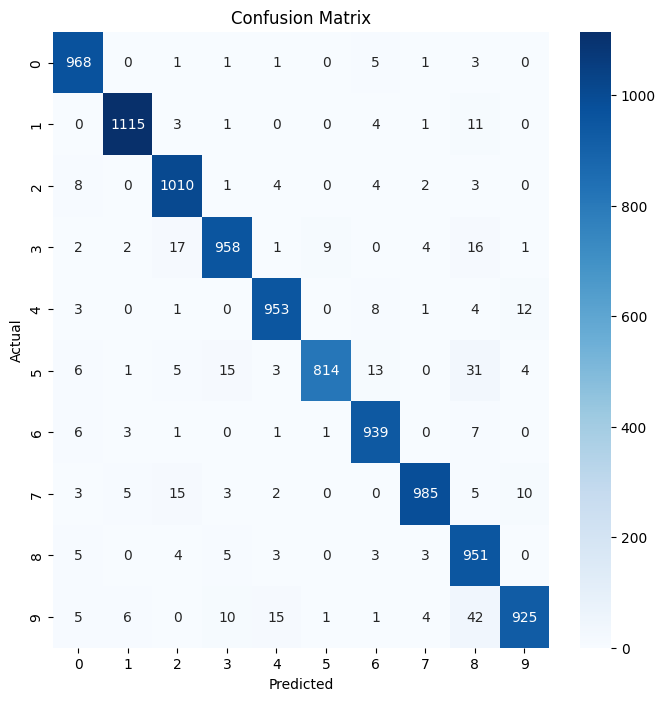

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get all the true labels and predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()